In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shutil
import tensorflow as tf
import tensorflow_addons as tfa

from os import listdir
from os.path import isfile, join
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
autotune = tf.data.AUTOTUNE


In [7]:
monet_dir = 'data/monet_jpg/'
photo_dir = 'data/photo_jpg/'

In [8]:
# retrieve filenames
monet_filenames = [join(monet_dir, f) for f in listdir(monet_dir) if isfile(join(monet_dir, f))]
photo_filenames = [join(photo_dir, f) for f in listdir(photo_dir) if isfile(join(photo_dir, f))]

In [9]:
# convert to np.arrays
monet_files = [np.array(Image.open(f)) for f in monet_filenames]
photo_files = [np.array(Image.open(f)) for f in photo_filenames]

In [10]:
# some metrics
print("monet files: " + str(len(monet_files)))
print("photo files: " + str(len(photo_files)))
print("image shape: " + str(monet_files[1].shape))

monet files: 300
photo files: 7038
image shape: (256, 256, 3)


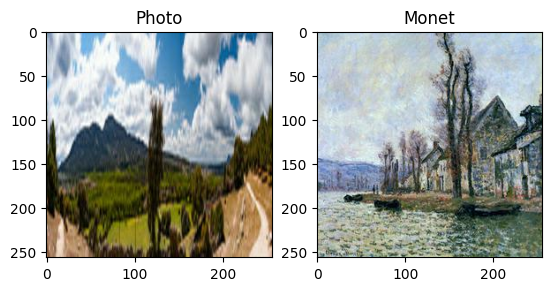

In [11]:
# let's print some examples
plt.subplot(121)
plt.title('Photo')
plt.imshow(mpimg.imread(photo_filenames[42]))

plt.subplot(122)
plt.title('Monet')
plt.imshow(mpimg.imread(monet_filenames[42]))

In [14]:
# retrieving tfrec
monet_tfrec = tf.io.gfile.glob(str('data/monet_tfrec/*.tfrec'))
photo_tfrec = tf.io.gfile.glob(str('data/photo_tfrec/*.tfrec'))

In [15]:
# show number of files
print('Monet TFRecord Files:', len(monet_tfrec))
print('Photo TFRecord Files:', len(photo_tfrec))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [16]:
# image size
IMAGE_SIZE = [256, 256]

# allows to decode an image
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# read teh tfrec file format
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [17]:
# load all tfrec
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

In [18]:
# load tfrec datasets
monet_ds = load_dataset(monet_tfrec, labeled=True).batch(1)
photo_ds = load_dataset(photo_tfrec, labeled=True).batch(1)

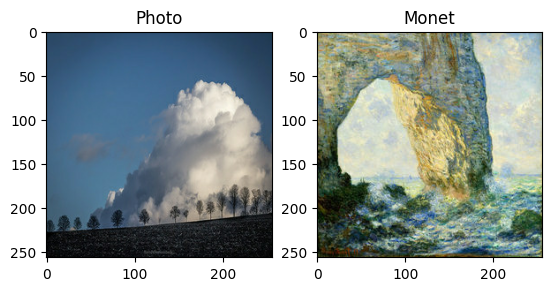

In [19]:
# retrieve an example of each and print them
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [20]:
# number of channel
OUTPUT_CHANNELS = 3

# function to reduce the image size
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [21]:
# function to augment the image size
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [22]:
# function to generate new image
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [23]:
# function to determine if an image is real or fake
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [24]:
# instance both generators and discriminators
monet_generator = Generator()
photo_generator = Generator()

monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

In [25]:
# main class to link generators and discriminator into a trainable solution
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [26]:
# loss function for the discriminator
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [27]:
# loss function for the generator
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [28]:
# loss for the cycle consistency
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [29]:
# loss for the identity
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [30]:
# instance all necessary optimizer
monet_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [31]:
# instance the model
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

# compile the model
cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [32]:
# train the model
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)


Epoch 1/20
300/300 [==============================] - 700s 2s/step - monet_gen_loss: 6.2490 - photo_gen_loss: 6.5093 - monet_disc_loss: 0.5830 - photo_disc_loss: 0.5552
Epoch 2/20
300/300 [==============================] - 643s 2s/step - monet_gen_loss: 4.1356 - photo_gen_loss: 4.4190 - monet_disc_loss: 0.6443 - photo_disc_loss: 0.4979
Epoch 3/20
300/300 [==============================] - 648s 2s/step - monet_gen_loss: 3.8839 - photo_gen_loss: 4.3348 - monet_disc_loss: 0.5853 - photo_disc_loss: 0.4118
Epoch 4/20
300/300 [==============================] - 657s 2s/step - monet_gen_loss: 4.2023 - photo_gen_loss: 4.5273 - monet_disc_loss: 0.4618 - photo_disc_loss: 0.4123
Epoch 5/20
300/300 [==============================] - 655s 2s/step - monet_gen_loss: 4.3135 - photo_gen_loss: 4.4885 - monet_disc_loss: 0.4950 - photo_disc_loss: 0.4794
Epoch 6/20
300/300 [==============================] - 656s 2s/step - monet_gen_loss: 4.0311 - photo_gen_loss: 4.3191 - monet_disc_loss: 0.5955 - photo_disc

In [ ]:
# display several results

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save("images/" + str(i) + ".jpg")
    i += 1